In [160]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../')
from makePop_while import *
from scipy.stats import gaussian_kde
import corner
import json
from tqdm.notebook import tqdm
from makeCorner import *
from scipy.ndimage.filters import gaussian_filter1d

plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams["text.latex.preamble"] = [r'\usepackage{xfrac}']

## 1. Fiducial Maxwellian

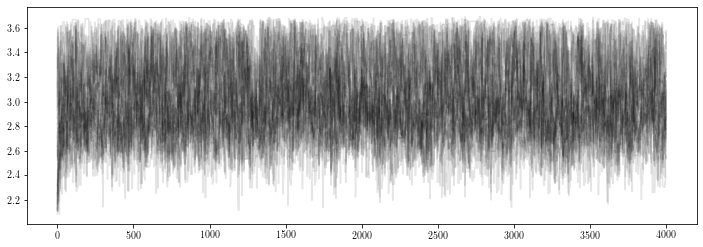

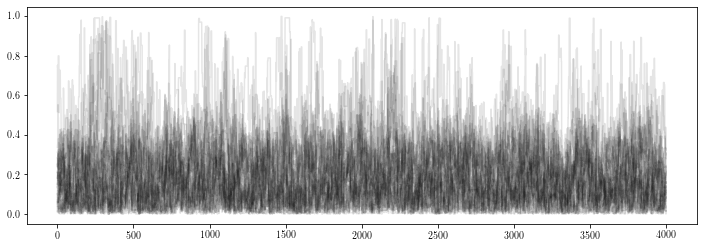

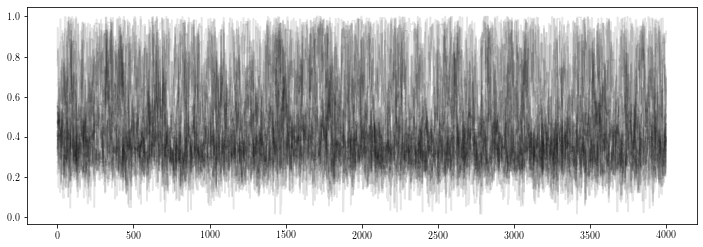

In [161]:
samps = np.load('../output/emcee_samples_maxwellian_beta0.9_perfectAlignment.npy')
for j in range(3):
    fig,ax = plt.subplots(figsize=(12,4))
    for i in range(32):
        ax.plot(samps[i,:,j],alpha=0.1,color='black')
    plt.show()

In [204]:
collapsed_samps = np.load('../output/processed_emcee_samples_maxwellian_beta0.9_perfectAlignment.npy')[()]

In [163]:
nDraws=600
nBinaries=200
pops = np.zeros((nDraws,nBinaries))
pops_p = np.zeros((nDraws,nBinaries))

chosenInds = np.random.choice(np.arange(collapsed_samps.shape[0]),size=nDraws,replace=False)
chosenSamps = collapsed_samps[chosenInds,:]

for i,samp in tqdm(enumerate(chosenSamps),total=nDraws):
            
    try:
        binaries,t,s,m,success = getPopRecursion(nBinaries,1.,samp[1],samp[2],0.,"maxwellian",[10.**samp[0],10.**samp[0]],0.9,efficiencyThreshold=1e-4)
    except RecursionError:
        print(samp)
        continue
    
    chi_effectives = np.array([b.chi_effective() for b in binaries[:nBinaries]])
    chi_ps = np.array([b.chi_p() for b in binaries[:nBinaries]])
    pops[i,:] = chi_effectives
    pops_p[i,:] = chi_ps

./../makePop_while.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  error = 1./np.sqrt(final_binaries.size)


In [164]:
spinData = {
    'chi_eff':pops.tolist(),
    'chi_p':pops_p.tolist()
}

with open('processed-data/maxwellian_default.json','w') as jf:
    json.dump(spinData,jf)

In [200]:
with open('processed-data/maxwellian_default.json','r') as jf:
    spinData = json.load(jf)
    
pops = spinData['chi_eff']
pops_p = spinData['chi_p']

In [165]:
import json
with open("./../input/Multiple-Fig-Data/effective_spin_ppd/gaussian-spin-xeff-xp-ppd-data.json","r") as jf:
    gaussian_data = json.load(jf)

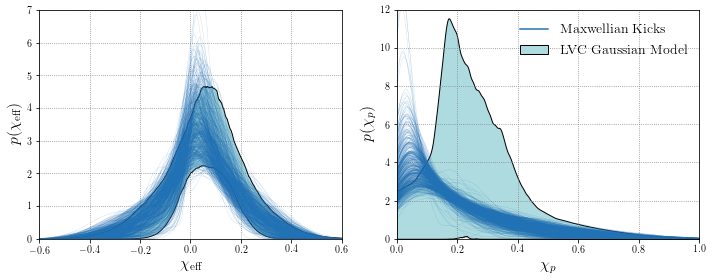

In [166]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)

ax.fill_between(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.05,axis=0),
        np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.95,axis=0),facecolor='#addbe0',edgecolor=None)
ax.plot(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.05,axis=0),
        lw=1,color='black')
ax.plot(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.95,axis=0),
        lw=1,color='black')

grid = np.linspace(-1,1,200)
for pop in pops:
    kde = gaussian_kde(pop)
    ax.plot(grid,kde(grid),color='#2171b5',lw=0.3,alpha=0.3)
        
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,7)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\chi_\mathrm{eff}$",fontsize=16)
ax.set_ylabel(r"$p(\chi_\mathrm{eff})$",fontsize=16)

ax = fig.add_subplot(122)

grid = np.linspace(0,1,200)
for pop in pops_p:
    kde = gaussian_kde(pop)
    h2, = ax.plot(grid,kde(grid)/np.trapz(kde(grid),grid),color='#2171b5',lw=0.3,alpha=0.3)

h1 = ax.fill_between(gaussian_data['chi_p_grid'],
        np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.05,axis=0),
        gaussian_filter1d(np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.95,axis=0),5),
        facecolor='#addbe0',
        edgecolor='black',
        zorder=-2)
#ax.plot(gaussian_data['chi_p_grid'],np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.05,axis=0),
#        lw=1,color='black',zorder=-1)
#ax.plot(gaussian_data['chi_p_grid'],
#        gaussian_filter1d(np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.95,axis=0),5),
#        lw=1,color='black',zorder=-1)

ax.set_xlim(0,1)
ax.set_ylim(0,12)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\chi_p$",fontsize=16)
ax.set_ylabel(r"$p(\chi_p)$",fontsize=16)

leg = ax.legend(handles=[h2,h1],labels=['Maxwellian Kicks','LVC Gaussian Model'],loc='upper right',frameon=False,fontsize=14)
leg.get_lines()[0].set_linewidth(1.5)
leg.get_lines()[0].set_alpha(1)

plt.tight_layout()
plt.savefig('./maxwellian_fiducial.pdf',bbox_inches='tight')
plt.show()

In [201]:
collapsed_samps_check = np.load('../output/processed_emcee_samples_maxwellian_beta0.9_perfectAlignment_efficiencyCheck.npy')[()]

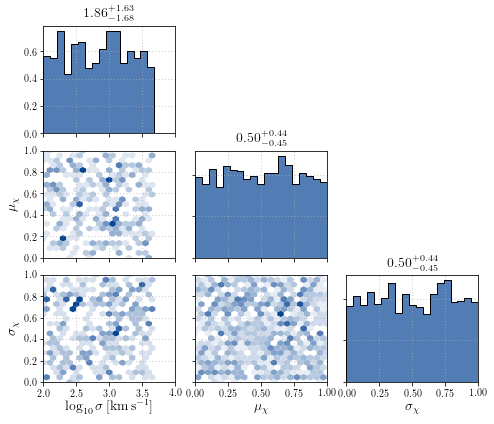

In [202]:
toPlot = {
    'sigma':{'data':collapsed_samps_check[:,0],'plot_bounds':(2,4),'label':r'$\log_{10}\sigma\,[\mathrm{km}\,\mathrm{s}^{-1}]$'},
    'mu_chi':{'data':collapsed_samps_check[:,1],'plot_bounds':(0,1),'label':r'$\mu_\chi$'},
    'sigma_chi':{'data':collapsed_samps_check[:,2],'plot_bounds':(0,1),'label':r'$\sigma_\chi$'}
}

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#084594')
fig.subplots_adjust(wspace=0.15, hspace=0.16)
plt.show()

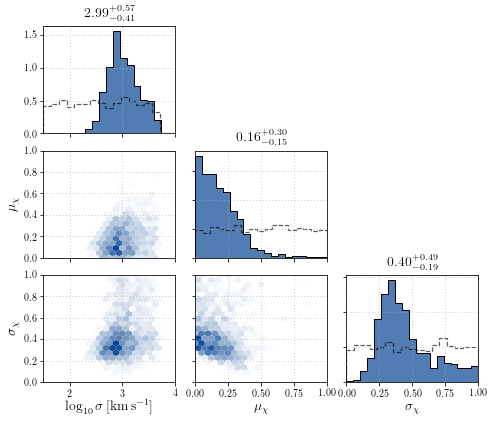

In [205]:
toPlot = {
    'sigma':{'data':collapsed_samps[:,0],'plot_bounds':(1.5,4),'label':r'$\log_{10}\sigma\,[\mathrm{km}\,\mathrm{s}^{-1}]$'},
    'mu_chi':{'data':collapsed_samps[:,1],'plot_bounds':(0,1),'label':r'$\mu_\chi$'},
    'sigma_chi':{'data':collapsed_samps[:,2],'plot_bounds':(0,1),'label':r'$\sigma_\chi$'}
}

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#084594')

ax_list = fig.axes
ax_list[0].hist(collapsed_samps_check[:,0],density=True,histtype='step',
                bins=np.linspace(1.5,4,18),color='black',ls='--',zorder=1,lw=1.2,alpha=0.65)
ax_list[3].hist(collapsed_samps_check[:,1],density=True,histtype='step',
                bins=np.linspace(0,1,18),color='black',ls='--',zorder=1,lw=1.2,alpha=0.65)
ax_list[5].hist(collapsed_samps_check[:,2],density=True,histtype='step',
                bins=np.linspace(0,1,18),color='black',ls='--',zorder=1,lw=1.2,alpha=0.65)

fig.subplots_adjust(wspace=0.15, hspace=0.16)
plt.savefig('./corner_maxwellian_fiducial.pdf',bbox_inches='tight')
plt.show()

## 2. Fiducial Asymmetric

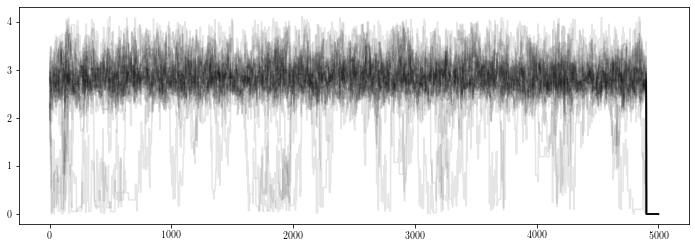

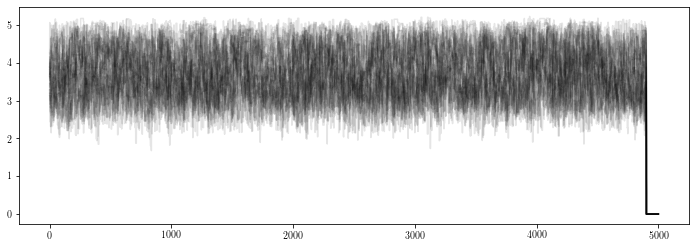

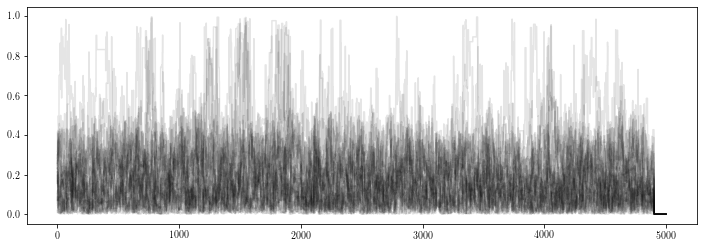

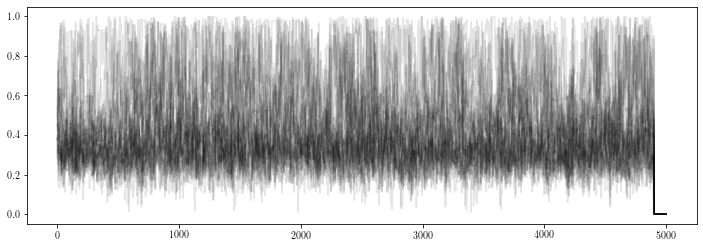

In [172]:
samps = np.load('../output/emcee_samples_asymmetric_beta0.9_perfectAlignment.npy')
for j in range(4):
    fig,ax = plt.subplots(figsize=(12,4))
    for i in range(32):
        ax.plot(samps[i,:,j],alpha=0.1,color='black')
    plt.show()

In [176]:
collapsed_samps = np.load('../output/processed_emcee_samples_asymmetric_beta0.9_perfectAlignment.npy')[()]
print(collapsed_samps.shape)

(1376, 4)


In [ ]:
nDraws=600
nBinaries=200
pops = np.zeros((nDraws,nBinaries))
pops_p = np.zeros((nDraws,nBinaries))

chosenInds = np.random.choice(np.arange(collapsed_samps.shape[0]),size=nDraws,replace=False)
chosenSamps = collapsed_samps[chosenInds,:]

for i,samp in tqdm(enumerate(chosenSamps),total=nDraws):
            
    try:
        binaries,t,s,m,success = getPopRecursion(nBinaries,1.,samp[2],samp[3],0,"maxwellian",[10.**samp[0],10.**samp[1]],0.9,efficiencyThreshold=1e-4)
    except RecursionError:
        print(samp)
        continue
    
    chi_effectives = np.array([b.chi_effective() for b in binaries[:nBinaries]])
    chi_ps = np.array([b.chi_p() for b in binaries[:nBinaries]])
    pops[i,:] = chi_effectives
    pops_p[i,:] = chi_ps

In [75]:
spinData = {
    'chi_eff':pops.tolist(),
    'chi_p':pops_p.tolist()
}

with open('processed-data/asymmetric_default.json','w') as jf:
    json.dump(spinData,jf)

In [188]:
with open('processed-data/asymmetric_default.json','r') as jf:
    spinData = json.load(jf)
    
pops = spinData['chi_eff']
pops_p = spinData['chi_p']

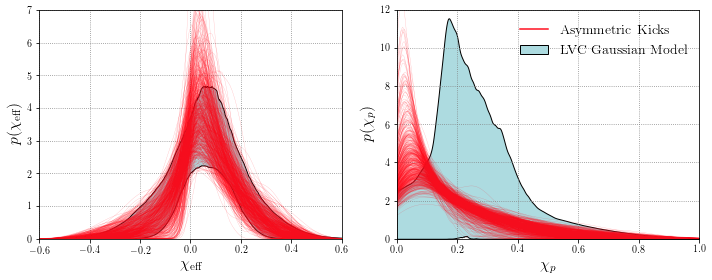

In [189]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)

ax.fill_between(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.05,axis=0),
        np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.95,axis=0),facecolor='#addbe0',edgecolor=None)
ax.plot(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.05,axis=0),
        lw=1,color='black')
ax.plot(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.95,axis=0),
        lw=1,color='black')

grid = np.linspace(-1,1,200)
for pop in pops:
    kde = gaussian_kde(pop)
    ax.plot(grid,kde(grid),color='#ff0d1d',lw=0.3,alpha=0.3)
        
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,7)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\chi_\mathrm{eff}$",fontsize=16)
ax.set_ylabel(r"$p(\chi_\mathrm{eff})$",fontsize=16)

ax = fig.add_subplot(122)

h1 = ax.fill_between(gaussian_data['chi_p_grid'],
        np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.05,axis=0),
        gaussian_filter1d(np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.95,axis=0),5),
        facecolor='#addbe0',
        edgecolor='black',
        zorder=-2)

grid = np.linspace(0,1,200)
for pop in pops_p:
    kde = gaussian_kde(pop)
    h2, = ax.plot(grid,kde(grid)/np.trapz(kde(grid),grid),color='#ff0d1d',lw=0.3,alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,12)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\chi_p$",fontsize=16)
ax.set_ylabel(r"$p(\chi_p)$",fontsize=16)

leg = ax.legend(handles=[h2,h1],labels=['Asymmetric Kicks','LVC Gaussian Model'],loc='upper right',frameon=False,fontsize=14)
leg.get_lines()[0].set_linewidth(1.5)
leg.get_lines()[0].set_alpha(1)

plt.tight_layout()
plt.savefig('./asymmetric_fiducial.pdf',bbox_inches='tight')
plt.show()

In [190]:
collapsed_samps_check = np.load('../output/processed_emcee_samples_asymmetric_beta0.9_perfectAlignment_efficiencyCheck.npy')[()]

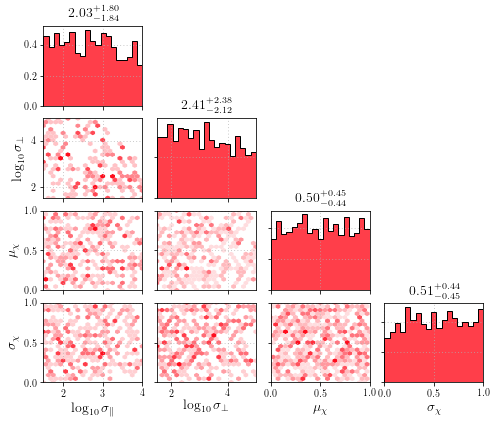

In [191]:
toPlot = {
    'sigma1':{'data':collapsed_samps_check[:,0],'plot_bounds':(1.5,4),'label':r'$\log_{10}\sigma_\parallel$'},
    'sigma2':{'data':collapsed_samps_check[:,1],'plot_bounds':(1.5,5),'label':r'$\log_{10}\sigma_\perp$'},
    'mu_chi':{'data':collapsed_samps_check[:,2],'plot_bounds':(0,1),'label':r'$\mu_\chi$'},
    'sigma_chi':{'data':collapsed_samps_check[:,3],'plot_bounds':(0,1),'label':r'$\sigma_\chi$'}
}

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#ff0d1d',hist_alpha=0.8)
fig.subplots_adjust(wspace=0.15, hspace=0.16)
plt.show()

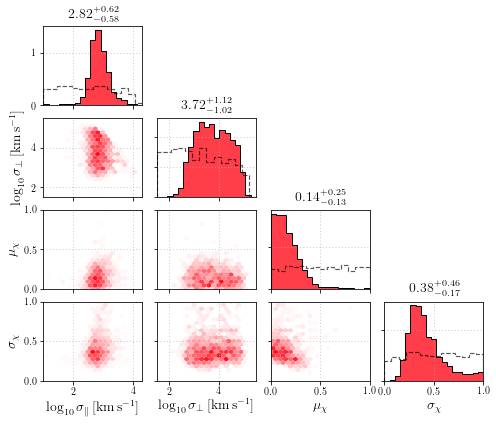

In [199]:
str_parallel="\log_{10}{\fontsize{20pt}{1em}\selectfont{}{\sfrac{\sigma_\parallel}{\mathrm{km}\,\mathrm{s}^{-1}}}}"

toPlot = {
    'sigma1':{'data':collapsed_samps[:,0],'plot_bounds':(1.,4.3),'label':r'$\log_{10}\sigma_\parallel\,[\mathrm{km}\,\mathrm{s}^{-1}]$'},
    'sigma2':{'data':collapsed_samps[:,1],'plot_bounds':(1.5,5.5),'label':r'$\log_{10}\sigma_\perp\,[\mathrm{km}\,\mathrm{s}^{-1}]$'},
    'mu_chi':{'data':collapsed_samps[:,2],'plot_bounds':(0,1),'label':r'$\mu_\chi$'},
    'sigma_chi':{'data':collapsed_samps[:,3],'plot_bounds':(0,1),'label':r'$\sigma_\chi$'}
}

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#ff0d1d',hist_alpha=0.8)

ax_list = fig.axes
ax_list[0].hist(collapsed_samps_check[:,0],density=True,histtype='step',
                bins=np.linspace(1.,4.3,15),color='black',ls='--',zorder=1,lw=1.2,alpha=0.65)
ax_list[4].hist(collapsed_samps_check[:,1],density=True,histtype='step',
                bins=np.linspace(1.5,5.5,15),color='black',ls='--',zorder=1,lw=1.2,alpha=0.65)
ax_list[7].hist(collapsed_samps_check[:,2],density=True,histtype='step',
                bins=np.linspace(0,1,15),color='black',ls='--',zorder=1,lw=1.2,alpha=0.65)
ax_list[9].hist(collapsed_samps_check[:,3],density=True,histtype='step',
                bins=np.linspace(0,1,15),color='black',ls='--',zorder=1,lw=1.2,alpha=0.65)

fig.subplots_adjust(wspace=0.15, hspace=0.16)
plt.savefig('./corner_asymmetric_fiducial.pdf',bbox_inches='tight')
plt.show()

## Combined Posteriors

In [206]:
maxwellian_samps = np.load('../output/processed_emcee_samples_maxwellian_beta0.9_perfectAlignment.npy')[()]
asymmetric_samps = np.load('../output/processed_emcee_samples_asymmetric_beta0.9_perfectAlignment.npy')[()]

maxwellian_priors = np.load('../output/processed_emcee_samples_maxwellian_beta0.9_perfectAlignment_efficiencyCheck.npy')[()]
asymmetric_priors = np.load('../output/processed_emcee_samples_asymmetric_beta0.9_perfectAlignment_efficiencyCheck.npy')[()]

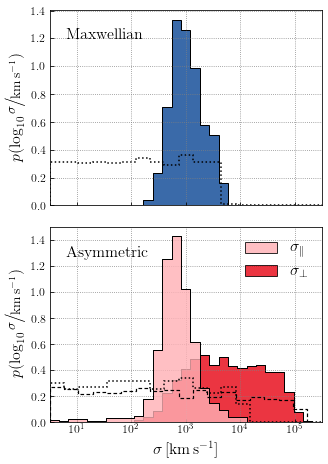

In [213]:
fig = plt.figure(figsize=(4.75,6.5))

ax = fig.add_subplot(211)
ax.hist(maxwellian_samps[:,0],density=True,histtype='stepfilled',bins=np.linspace(0.5,5.5,30),
        color='#084594',alpha=0.8)
ax.hist(maxwellian_samps[:,0],density=True,histtype='step',bins=np.linspace(0.5,5.5,30),color='black')
ax.hist(maxwellian_priors[:,0],density=True,histtype='step',bins=np.linspace(0.5,5.5,20),color='black',linestyle=':',lw=1.5)
ax.set_xticklabels([])
ax.tick_params(direction="in",labelsize=12)

ax.set_xlim(0.5,5.5)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_ylabel(r"$p(\log_{10}{\fontsize{20pt}{1em}\selectfont{}{\sfrac{\sigma}{\mathrm{km}\,\mathrm{s}^{-1}}}})$",fontsize=16)

ax.text(0.06,0.85,'Maxwellian',transform=ax.transAxes,fontsize=16)

ax = fig.add_subplot(212)

ax.hist(asymmetric_samps[:,0],density=True,histtype='stepfilled',bins=np.linspace(0.5,5.5,30),
        color='#ffb0b5',alpha=0.8,edgecolor='black',label='$\sigma_\parallel$',zorder=2)
ax.hist(asymmetric_samps[:,0],density=True,histtype='step',bins=np.linspace(0.5,5.5,30),edgecolor='black',zorder=2)

ax.hist(asymmetric_samps[:,1],density=True,histtype='stepfilled',bins=np.linspace(0.5,5.5,30),
        color='#e60211',alpha=0.8,edgecolor='black',label='$\sigma_\perp$',zorder=1)
ax.hist(asymmetric_samps[:,1],density=True,histtype='step',bins=np.linspace(0.5,5.5,30),edgecolor='black',zorder=1)

ax.hist(asymmetric_priors[:,0],density=True,histtype='step',bins=np.linspace(0.5,5.5,20),color='black',
        linestyle=':',lw=1.5,zorder=3)
ax.hist(asymmetric_priors[:,1],density=True,histtype='step',bins=np.linspace(0.5,5.5,20),color='black',
        linestyle=(0,(3,2)),lw=1.2,zorder=3)

ax.text(0.06,0.85,'Asymmetric',transform=ax.transAxes,fontsize=16)
ax.legend(loc='upper right',frameon=False,fontsize=16)
ax.tick_params(direction="in",labelsize=12)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(["$10^{0}$".format(x) for x in [1,2,3,4,5]])
ax.set_xlim(0.5,5.5)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\sigma\,[\mathrm{km}\,\mathrm{s}^{-1}]$",fontsize=16)
ax.set_ylabel(r"$p(\log_{10}{\fontsize{20pt}{1em}\selectfont{}{\sfrac{\sigma}{\mathrm{km}\,\mathrm{s}^{-1}}}})$",fontsize=16)

plt.tight_layout()
plt.savefig('combined_kick_distributions.pdf',bbox_inches='tight')
plt.show()

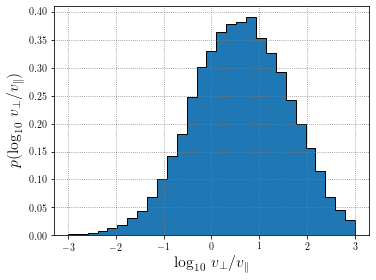

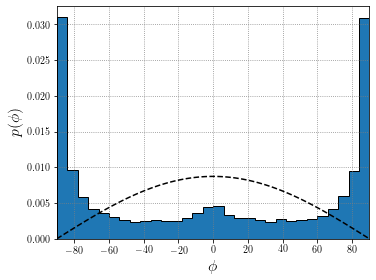

In [214]:
sig_planes = asymmetric_samps[:,0]
sig_perps = asymmetric_samps[:,1]

vxs = np.array([])
vys = np.array([])
vzs = np.array([])
for i in range(sig_planes.size):
    
    vx,vy,vz = np.transpose([random_kick(10.**sig_planes[i],10.**sig_perps[i]) for j in range(20)])
    vxs = np.append(vxs,vx)
    vys = np.append(vys,vy)
    vzs = np.append(vzs,vz)
    
v_planes = np.sqrt(vxs**2.+vys**2.)
v_perps = np.abs(vzs)
angles = np.arctan2(vzs,v_planes)
angles*= 180./np.pi

fig,ax = plt.subplots(figsize=(5.33,4))
ax.hist(np.log10(v_perps/v_planes),histtype='stepfilled',
        bins=np.linspace(-3,3,30),edgecolor='black',density=True)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\log_{10}\,v_\perp/v_\parallel$",fontsize=16)
ax.set_ylabel(r"$p(\log_{10}\,v_\perp/v_\parallel)$",fontsize=16)
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(figsize=(5.33,4))
ax.hist(angles,histtype='stepfilled',bins=30,edgecolor='black',density=True)

xs = np.linspace(-90.,90.,100)
ys = np.cos(xs*np.pi/180.)
ys /= np.trapz(ys,xs)
ax.plot(xs,ys,color='black',ls='--')

ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\phi$",fontsize=16)
ax.set_ylabel(r"$p(\phi)$",fontsize=16)
ax.set_xlim(-90,90)
plt.tight_layout()
plt.savefig('polar_angle.pdf',bbox_inches='tight')
plt.show()

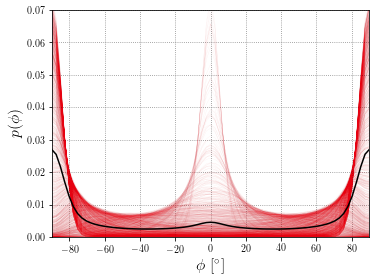

In [215]:
sig_planes = asymmetric_samps[:,0]
sig_perps = asymmetric_samps[:,1]
fig,ax = plt.subplots(figsize=(5.33,4))

xs = np.linspace(-1,1,100)
phis = np.linspace(-90,90,75)
ppd = np.zeros(phis.size)
equatorial = 0

for i in tqdm(range(sig_planes.size)):
    
    vx,vy,vz = np.transpose([random_kick(10.**sig_planes[i],10.**sig_perps[i]) for j in range(3000)])
    v_planes = np.sqrt(vx**2.+vy**2.)
    kick_angles = np.arctan2(vz,v_planes)
    
    if np.mean(v_planes)>np.mean(np.abs(vz)):
        equatorial += 1
    
    kick_angles*= 180./np.pi
    kick_angles = np.concatenate([kick_angles,-90.-(kick_angles+90),90+(90-kick_angles)])
    kde = gaussian_kde(kick_angles,bw_method=kick_angles.size**(-1./5.)*0.2)
    norm = np.trapz(kde(phis),phis)    
    ppd += kde(phis)/norm/sig_planes.size 
    ax.plot(phis,kde(phis)/norm,color='#e60211',alpha=0.1,lw=0.2)

    # Note that dP/dphi = dP/dsin(phi) *cos(phi)
    #sin_angles = np.sin(kick_angles)
    #sin_angles = np.concatenate([sin_angles,-1-(sin_angles+1),1+(1.-sin_angles)])
    #kde = gaussian_kde(sin_angles,bw_method=sin_angles.size**(-1./5.))
    #norm = np.trapz(kde(np.sin(phis))*np.cos(phis),phis)    
    #ppd += kde(np.sin(phis))*np.cos(phis)/norm/200.    
    #ax.plot(phis*180/np.pi,kde(np.sin(phis))*np.cos(phis)/norm,color='#e60211',alpha=0.1,lw=0.2)

ax.plot(phis,ppd,color='black')
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\phi\,\,[{}^\circ]$",fontsize=16)
ax.set_ylabel(r"$p(\phi)$",fontsize=16)
ax.set_xlim(-90,90)
ax.set_ylim(0,0.07)
plt.tight_layout()
plt.savefig('./polar_angles_alt.pdf',bbox_inches='tight')
plt.show()

In [220]:
sigMaxwellian = 10.**maxwellian_samps[:,0]
mu_chi_maxwellian = maxwellian_samps[:,1]
sig_chi_maxwellian = maxwellian_samps[:,2]

sigAsymmetricPar = 10.**asymmetric_samps[:,0]
sigAsymmetricPerp = 10.**asymmetric_samps[:,1]
mu_chi_asymmetric = asymmetric_samps[:,2]
sig_chi_asymmetric = asymmetric_samps[:,3]

with open('latex-macros.txt','w') as outfile:
    
    outfile.write("\\newcommand{{\sigmaMaxwellianMedian}}{{{0:.1f}}}\n".format(np.median(sigMaxwellian)))
    outfile.write("\\newcommand{{\sigmaMaxwellianUpperError}}{{{0:.1f}}}\n".format(
        np.quantile(sigMaxwellian,0.95)-np.median(sigMaxwellian)))
    outfile.write("\\newcommand{{\sigmaMaxwellianLowerError}}{{{0:.1f}}}\n".format(
        np.median(sigMaxwellian)-np.quantile(sigMaxwellian,0.05)))
    outfile.write("\\newcommand{{\sigmaMaxwellianLowerBound}}{{{0:.1f}}}\n".format(np.quantile(sigMaxwellian,0.01)))
    outfile.write("\n")
    
    outfile.write("\\newcommand{{\sigmaMaxwellianMedianModHundred}}{{{0:.1f}}}\n".format(
        np.median(sigMaxwellian/100.)))
    outfile.write("\\newcommand{{\sigmaMaxwellianUpperErrorModHundred}}{{{0:.1f}}}\n".format(
        (np.quantile(sigMaxwellian,0.95)-np.median(sigMaxwellian))/100.))
    outfile.write("\\newcommand{{\sigmaMaxwellianLowerErrorModHundred}}{{{0:.1f}}}\n".format(
        (np.median(sigMaxwellian)-np.quantile(sigMaxwellian,0.05))/100.))
    outfile.write("\n")
    
    outfile.write("\\newcommand{{\sigmaAsymmetricParMedian}}{{{0:.1f}}}\n".format(np.median(sigAsymmetricPar)))
    outfile.write("\\newcommand{{\sigmaAsymmetricParUpperError}}{{{0:.1f}}}\n".format(
        np.quantile(sigAsymmetricPar,0.95)-np.median(sigAsymmetricPar)))
    outfile.write("\\newcommand{{\sigmaAsymmetricParLowerError}}{{{0:.1f}}}\n".format(
        np.median(sigAsymmetricPar)-np.quantile(sigAsymmetricPar,0.05)))
    outfile.write("\\newcommand{{\sigmaAsymmetricParLowerBound}}{{{0:.1f}}}\n".format(np.quantile(sigAsymmetricPar,0.01)))
    outfile.write("\n")
    
    outfile.write("\\newcommand{{\sigmaAsymmetricParMedianModHundred}}{{{0:.1f}}}\n".format(
        np.median(sigAsymmetricPar)/100.))
    outfile.write("\\newcommand{{\sigmaAsymmetricParUpperErrorModHundred}}{{{0:.1f}}}\n".format(
        (np.quantile(sigAsymmetricPar,0.95)-np.median(sigAsymmetricPar))/100.))
    outfile.write("\\newcommand{{\sigmaAsymmetricParLowerErrorModHundred}}{{{0:.1f}}}\n".format(
        (np.median(sigAsymmetricPar)-np.quantile(sigAsymmetricPar,0.05))/100.))
    outfile.write("\n")
    
    outfile.write("\\newcommand{{\sigmaAsymmetricPerpMedian}}{{{0:.1f}}}\n".format(np.median(sigAsymmetricPerp)))
    outfile.write("\\newcommand{{\sigmaAsymmetricPerpUpperError}}{{{0:.1f}}}\n".format(
        np.quantile(sigAsymmetricPerp,0.95)-np.median(sigAsymmetricPerp)))
    outfile.write("\\newcommand{{\sigmaAsymmetricPerpLowerError}}{{{0:.1f}}}\n".format(
        np.median(sigAsymmetricPerp)-np.quantile(sigAsymmetricPerp,0.05)))
    outfile.write("\\newcommand{{\sigmaAsymmetricPerpLowerBound}}{{{0:.1f}}}\n".format(np.quantile(sigAsymmetricPerp,0.01)))
    outfile.write("\n")
    
    outfile.write("\\newcommand{{\sigmaAsymmetricPerpMedianModThousand}}{{{0:.1f}}}\n".format(
        np.median(sigAsymmetricPerp)/1000.))
    outfile.write("\\newcommand{{\sigmaAsymmetricPerpUpperErrorModThousand}}{{{0:.1f}}}\n".format(
        (np.quantile(sigAsymmetricPerp,0.95)-np.median(sigAsymmetricPerp))/1000.))
    outfile.write("\\newcommand{{\sigmaAsymmetricPerpLowerErrorModThousand}}{{{0:.1f}}}\n".format(
        (np.median(sigAsymmetricPerp)-np.quantile(sigAsymmetricPerp,0.05))/1000.))
    outfile.write("\n")
    
    outfile.write("\\newcommand{{\muChiMaxwellianUpperLimit}}{{{0:.2f}}}\n".format(np.quantile(mu_chi_maxwellian,0.95)))
    outfile.write("\\newcommand{{\sigmaChiMaxwellianLowerLimit}}{{{0:.2f}}}\n".format(np.quantile(sig_chi_maxwellian,0.05)))
    outfile.write("\\newcommand{{\muChiAsymmetricUpperLimit}}{{{0:.2f}}}\n".format(np.quantile(mu_chi_asymmetric,0.95)))
    outfile.write("\\newcommand{{\sigmaChiAsymmetricLowerLimit}}{{{0:.2f}}}\n".format(np.quantile(sig_chi_asymmetric,0.05)))
    outfile.write("\n")
    
    outfile.write("\\newcommand{{\polarAngleQuantileFifty}}{{{0:.1f}}}\n".format(np.median(np.abs(kick_angles))))
    outfile.write("\\newcommand{{\polarAngleQuantileSeventyFive}}{{{0:.1f}}}\n".format(np.quantile(np.abs(kick_angles),0.75)))
    outfile.write("\\newcommand{{\isotropicPolarAngleQuantileFifty}}{{{0:.1f}}}\n".format(np.arcsin(0.5)))
    outfile.write("\\newcommand{{\isotropicPolarAngleQuantileSeventyFive}}{{{0:.1f}}}\n".format(np.arcsin(0.75)))

## Maxwellian: Beta=0.75

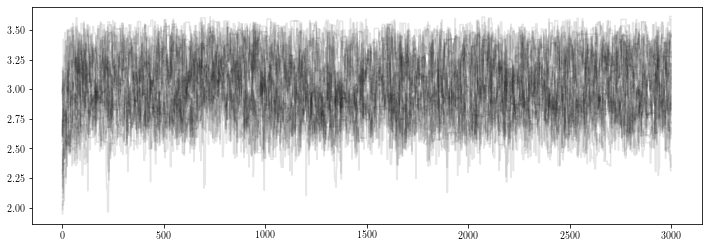

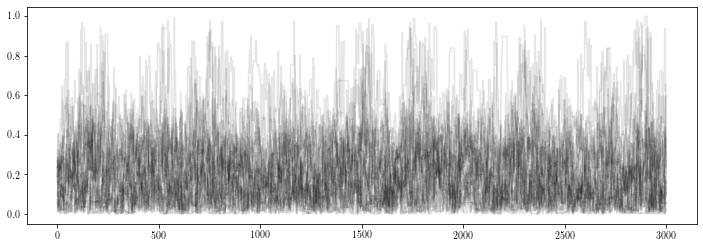

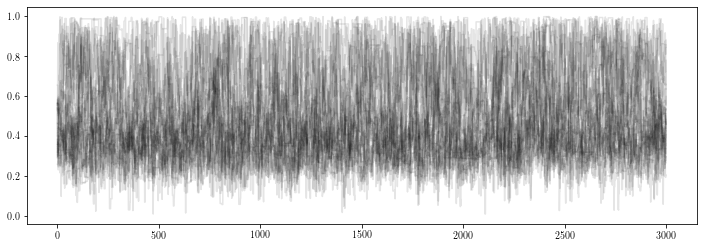

In [3]:
samps = np.load('../emcee_samples_maxwellian_beta_0.75.npy')
for j in range(3):
    fig,ax = plt.subplots(figsize=(12,4))
    for i in range(32):
        ax.plot(samps[i,:,j],alpha=0.1,color='black')
    plt.show()

In [5]:
collapsed_samps = np.load('../processed_emcee_samples_maxwellian_beta_0.75.npy')[()]

In [6]:
nDraws=600
nBinaries=100
pops = np.zeros((nDraws,nBinaries))
pops_p = np.zeros((nDraws,nBinaries))
m1s = np.zeros((nDraws,nBinaries))
m2s = np.zeros((nDraws,nBinaries))

chosenInds = np.random.choice(np.arange(collapsed_samps.shape[0]),size=nDraws,replace=False)
chosenSamps = collapsed_samps[chosenInds,:]

for i,samp in tqdm(enumerate(chosenSamps),total=nDraws):
            
    try:
        binaries,t,s,m,success = getPopRecursion(nBinaries,1.,samp[1],samp[2],10.*np.pi/180.,"maxwellian",[10.**samp[0],10.**samp[0]],0.75,efficiencyThreshold=1e-4)
    except RecursionError:
        print(samp)
        continue
    
    chi_effectives = np.array([b.chi_effective() for b in binaries[:100]])
    chi_ps = np.array([b.chi_p() for b in binaries[:100]])
    m1 = np.array([b.m1 for b in binaries[:100]])
    m2 = np.array([b.m2 for b in binaries[:100]])
    
    pops[i,:] = chi_effectives
    pops_p[i,:] = chi_ps
    m1s[i,:] = m1
    m2s[i,:] = m2

./../makePop_while.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  error = 1./np.sqrt(final_binaries.size)
./../makePop_while.py:115: RuntimeWarning: invalid value encountered in less
  merge += np.where(mergerTimes<1)[0].size
./../makePop_while.py:117: RuntimeWarning: invalid value encountered in less
  successful = ((survived==1)*(mergerTimes<1))


In [7]:
spinData = {
    'chi_eff':pops.tolist(),
    'chi_p':pops_p.tolist(),
    'm1':m1s.tolist(),
    'm2':m2s.tolist()
}

with open('processed-data/maxwellian_beta_0.75.json','w') as jf:
    json.dump(spinData,jf)

In [11]:
with open('processed-data/maxwellian_beta_0.75.json','r') as jf:
    spinData = json.load(jf)
    
pops = spinData['chi_eff']
pops_p = spinData['chi_p']

In [8]:
import json
with open("/home/thomas.callister/Simona/o3a-spin-studies/Postprocessing/gaussian-spin-xeff-xp-ppd-data.json","r") as jf:
    gaussian_data = json.load(jf)

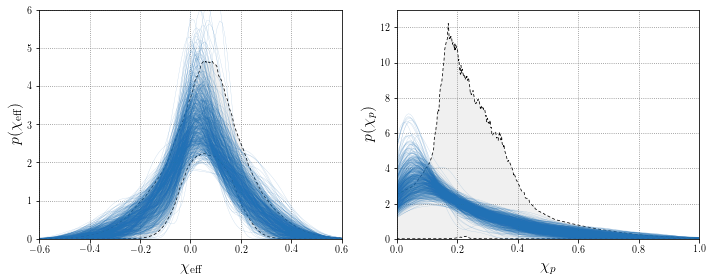

In [9]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)

ax.fill_between(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.05,axis=0),
        np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.95,axis=0),facecolor='#f0f0f0',edgecolor=None)
ax.plot(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.05,axis=0),
        lw=0.75,dashes=(4,3),color='black')
ax.plot(gaussian_data['chi_eff_grid'],np.quantile(np.array(gaussian_data['chi_eff_pdfs']),0.95,axis=0),
        lw=0.75,dashes=(4,3),color='black')

grid = np.linspace(-1,1,200)
for pop in pops:
    kde = gaussian_kde(pop)
    ax.plot(grid,kde(grid),color='#2171b5',lw=0.3,alpha=0.3)
        
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,6)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\chi_\mathrm{eff}$",fontsize=16)
ax.set_ylabel(r"$p(\chi_\mathrm{eff})$",fontsize=16)

ax = fig.add_subplot(122)

ax.fill_between(gaussian_data['chi_p_grid'],
        np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.05,axis=0),
        np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.95,axis=0),facecolor='#f0f0f0',
        edgecolor=None)
ax.plot(gaussian_data['chi_p_grid'],np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.05,axis=0),
        lw=0.75,dashes=(4,3),color='black')
ax.plot(gaussian_data['chi_p_grid'],np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.95,axis=0),
        lw=0.75,dashes=(4,3),color='black')

grid = np.linspace(0,1,200)
for pop in pops_p:
    kde = gaussian_kde(pop)
    ax.plot(grid,kde(grid)/np.trapz(kde(grid),grid),color='#2171b5',lw=0.3,alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,13)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$\chi_p$",fontsize=16)
ax.set_ylabel(r"$p(\chi_p)$",fontsize=16)

plt.tight_layout()
plt.savefig('./maxwellian_beta_0.75.pdf',bbox_inches='tight')
plt.show()

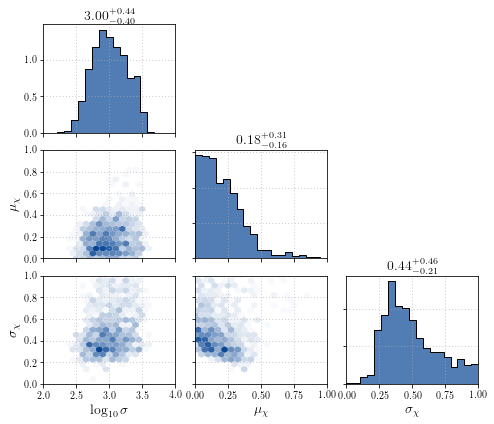

In [10]:
toPlot = {
    'sigma':{'data':collapsed_samps[:,0],'plot_bounds':(2,4),'label':r'$\log_{10}\sigma$'},
    'mu_chi':{'data':collapsed_samps[:,1],'plot_bounds':(0,1),'label':r'$\mu_\chi$'},
    'sigma_chi':{'data':collapsed_samps[:,2],'plot_bounds':(0,1),'label':r'$\sigma_\chi$'}
}

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#084594')
fig.subplots_adjust(wspace=0.15, hspace=0.16)
plt.savefig('./corner_maxwellian_beta_0.75.pdf',bbox_inches='tight')
plt.show()

In [20]:
print(np.quantile(10.**collapsed_samps[:,0],0.5))
print(np.quantile(10.**collapsed_samps[:,0],0.95)-np.quantile(10.**collapsed_samps[:,0],0.5))
print(np.quantile(10.**collapsed_samps[:,0],0.5)-np.quantile(10.**collapsed_samps[:,0],0.05))
print(np.quantile(10.**collapsed_samps[:,0],0.01))

1004.218284992993
1784.8172444215086
603.7105085908213
301.5050298525591


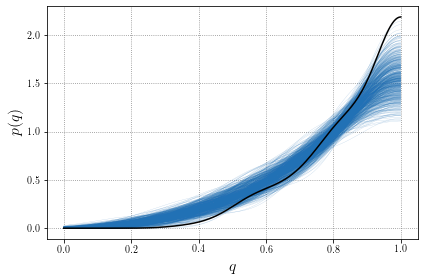

In [18]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)

grid = np.linspace(0,1,200)
for i in range(m1s.shape[0]):
    m1 = m1s[i,:]
    m2 = m2s[i,:]
    kde = gaussian_kde(np.concatenate([m2/m1,2-m2/m1]))
    ax.plot(grid,kde(grid),color='#2171b5',lw=0.3,alpha=0.3)
    
mMax = 75.
mMin = 5.
bq = 1.3
alpha = -2.2
new_m1 = np.power((mMax**(1.+alpha)-mMin**(1.+alpha))*np.random.random(300) + mMin**(1.+alpha),1./(1.+alpha))
new_m2 = np.power((new_m1**(1.+bq)-mMin**(1.+bq))*np.random.random(300)+mMin**(1.+bq),1./(1.+bq))
        
new_qs = np.concatenate([new_m2/new_m1,2-new_m2/new_m1])
new_kde = gaussian_kde(new_qs)
ax.plot(grid,new_kde(grid),color='black')
    
#ax.set_xlim(-0.6,0.6)
#ax.set_ylim(0,6)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel(r"$q$",fontsize=16)
ax.set_ylabel(r"$p(q)$",fontsize=16)

plt.tight_layout()
plt.show()

## SCRATCH

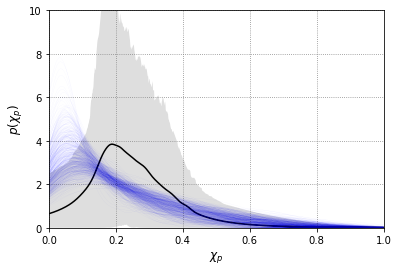

In [13]:
fig,ax = plt.subplots()

ax.fill_between(gaussian_data['chi_p_grid'],np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.05,axis=0),\
                np.quantile(np.array(gaussian_data['chi_p_pdfs']),0.95,axis=0),facecolor='lightgrey',alpha=0.75,zorder=-1)
ax.plot(gaussian_data['chi_p_grid'],np.mean(np.array(gaussian_data['chi_p_pdfs']),axis=0),color='black')

grid = np.linspace(0,1,200)
for pop in pops_p:
    
    if np.any(pop!=0.):    
        kde = gaussian_kde(pop)
        ax.plot(grid,kde(grid)/np.trapz(kde(grid),grid),color='blue',lw=0.1,alpha=0.1)

ax.set_xlim(0,1)
ax.set_ylim(0,10)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')

ax.set_xlabel(r"$\chi_p$",fontsize=12)
ax.set_ylabel(r"$p(\chi_p)$",fontsize=12)

plt.show()

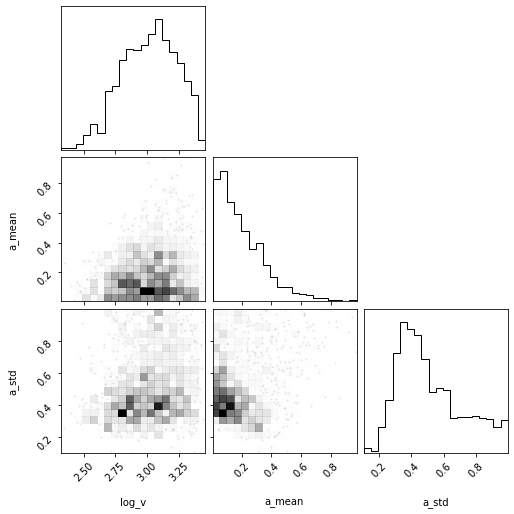

In [14]:
#labels=["sigma_v","v_perp","sigma_perp","a_mean","a_std"]
labels=["log_v","a_mean","a_std"]
#labels=["logR","v_parallel","v_perp","a_mean","a_std"]
#labels=["logR_min","delta logR","sigma_v","a_mean","a_std"]
corner.corner(collapsed_samps,plot_contours=False,labels=labels)
plt.show()

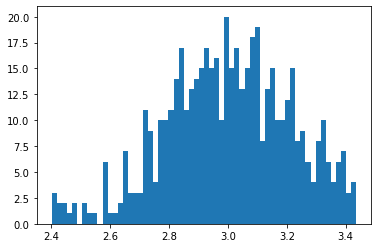

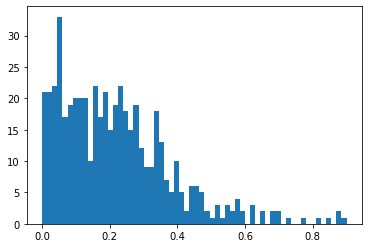

In [65]:
plt.hist(collapsed_samps[:,0],bins=60)
plt.show()
plt.hist(collapsed_samps[:,1],bins=60)
plt.show()

In [25]:
print(10.**np.quantile(collapsed_samps[:,0],0.05),10.**np.quantile(collapsed_samps[:,1],0.05))

99.21231426402304 209.300730265694


In [14]:
v_50 = np.quantile(collapsed_samps[:,0],0.5)
v_05 = np.quantile(collapsed_samps[:,0],0.05)
v_95 = np.quantile(collapsed_samps[:,0],0.95)
print(10.**v_50,10.**v_95-10.**v_50,10.**v_50-10.**v_05)

729.9207177889795 1396.1541238961577 477.3991356150028


In [15]:
v_50 = np.quantile(collapsed_samps[:,1],0.5)
v_05 = np.quantile(collapsed_samps[:,1],0.05)
v_95 = np.quantile(collapsed_samps[:,1],0.95)
print(10.**v_50,10.**v_95-10.**v_50,10.**v_50-10.**v_05)

2987.624893565502 10469.277845922967 2499.0493290845334


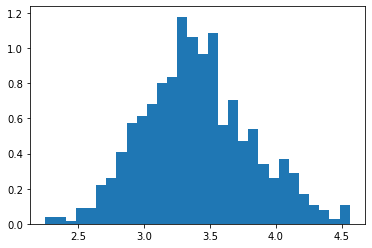

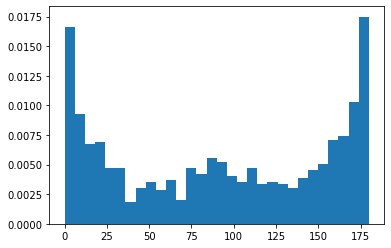

In [35]:
v_tot = np.zeros(len(collapsed_samps))
angle = np.zeros(len(collapsed_samps))

for i,samp in enumerate(collapsed_samps):   
    vx,vy,vz = random_kick(10.**samp[0],10.**samp[1])
    v_tot[i] = np.sqrt(vx**2.+vy**2.+vz**2.)
    angle[i] = np.arctan2(np.sqrt(vx**2.+vy**2.),vz)
    
plt.hist(np.log10(v_tot),bins=30,density=True)
plt.show()

plt.hist(angle*180./np.pi,bins=30,density=True)
plt.show()

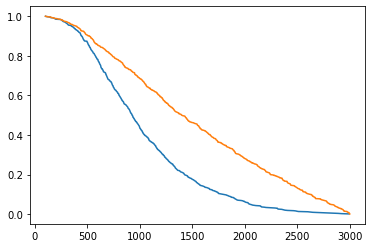

In [313]:
plt.plot(np.sort(collapsed_samps[:,1]),np.cumsum(np.ones(collapsed_samps[:,1].size))[::-1]/float(collapsed_samps[:,1].size))
plt.plot(np.sort(collapsed_samps[:,2]),np.cumsum(np.ones(collapsed_samps[:,2].size))[::-1]/float(collapsed_samps[:,2].size))
#plt.yscale('log')
plt.show()

In [76]:
binaries = getPopRecursion(1.,0.5,0.5,0.1,"directed",[np.log10(1000),np.log10(1500)])
m1 = np.array([b.m1 for b in binaries])
m2 = np.array([b.m2 for b in binaries])

TypeError: getPopRecursion() takes 8 positional arguments but 9 were given

In [85]:
mMin = 5.
mMax = 50.
alpha = -2.3
bq = 4.
n=1000
m1_test = np.power((mMax**(1.+alpha)-mMin**(1.+alpha))*np.random.random(n) + mMin**(1.+alpha),1./(1.+alpha))
m2_test = np.power((m1_test**(1.+bq)-mMin**(1.+bq))*np.random.random(n)+mMin**(1.+bq),1./(1.+bq))

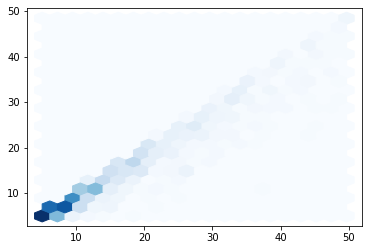

In [88]:
plt.hexbin(m1,m2,gridsize=20,cmap='Blues')

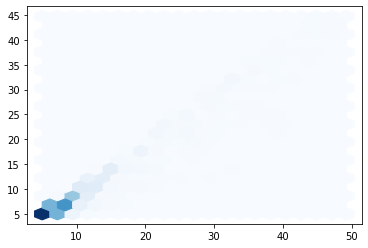

In [87]:
plt.hexbin(m1_test,m2_test,gridsize=20,cmap='Blues')

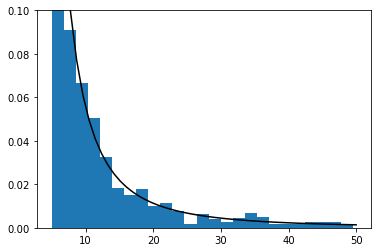

In [83]:
plt.hist(m1_test,bins=25,density=True)

xs = np.linspace(5,50)
a = -2.3
ys = (1+a)*xs**a/(50**(1.+a)-5.**(1+a))
plt.plot(xs,ys,color='black')
plt.ylim(0,0.1)

plt.show()

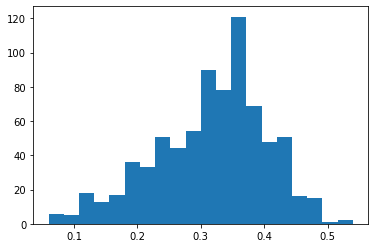

In [11]:
plt.hist(fracNegative,bins=20)
plt.show()

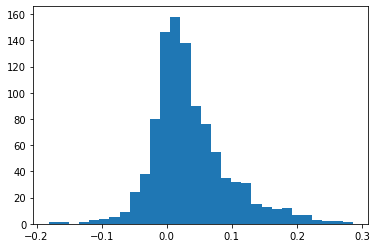

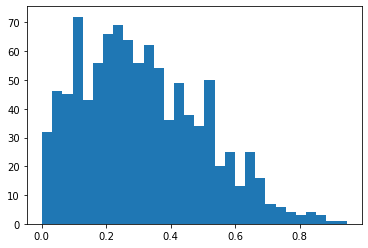

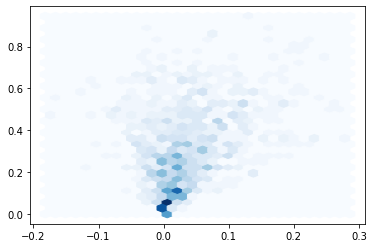

In [8]:
binaries = getPopRecursion(1000,1.2,0.4,0.3,0.,"directed",[np.log10(1000),np.log10(1500)])

chi_effectives = np.array([b.chi_effective() for b in binaries])
chi_ps = np.array([b.chi_p() for b in binaries])
masses = np.array([b.m1+b.m2 for b in binaries])
qs = np.array([b.m2/b.m1 for b in binaries])
plt.hist(chi_effectives,bins=30)
plt.show()
plt.hist(chi_ps,bins=30)
plt.show()
plt.hexbin(chi_effectives,chi_ps,gridsize=30,cmap='Blues')
plt.show()

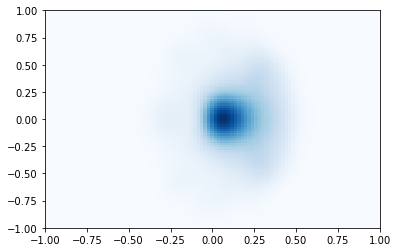

In [22]:
test = gaussian_kde([np.concatenate([chi_effectives,chi_effectives]),np.concatenate([chi_ps,-chi_ps])])

xs = np.linspace(-1,1,100)
ys = np.linspace(-1,1,95)
Xs,Ys = np.meshgrid(xs,ys)
zs = test([Xs.reshape(-1),Ys.reshape(-1)]).reshape((ys.size,xs.size))

plt.pcolormesh(xs,ys,zs,cmap='Blues')

In [14]:
plt.hexbin(chi_effectives,masses,gridsize=30,cmap='Blues')
plt.show()
plt.hexbin(chi_ps,masses,gridsize=30,cmap='Blues')
plt.show()

NameError: name 'masses' is not defined

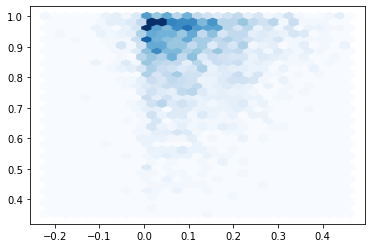

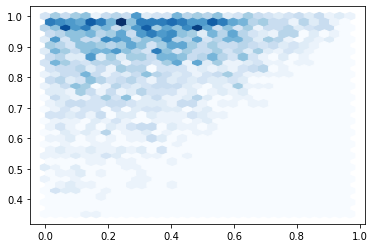

In [105]:
plt.hexbin(chi_effectives,qs,gridsize=30,cmap='Blues')
plt.show()
plt.hexbin(chi_ps,qs,gridsize=30,cmap='Blues')
plt.show()

(-0.75, 0.75)

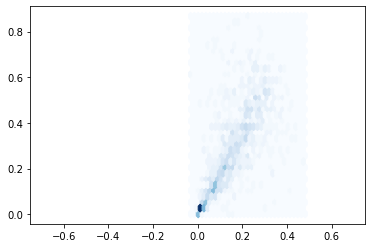

In [200]:
binaries = getPopRecursion(1000,0.,2000.,3.,10.,0.5,0.5,0.3)
chi_effectives = np.array([b.chi_effective() for b in binaries])
chi_ps = np.array([b.chi_p() for b in binaries])

kde_2d = gaussian_kde([chi_effectives,chi_ps])
plt.hexbin(chi_effectives,chi_ps,gridsize=30,cmap='Blues')
plt.xlim(-0.75,0.75)

In [201]:
xs=np.linspace(-1,1,200)
ys=np.linspace(0,1,190)
Xs,Ys = np.meshgrid(xs,ys)
Zs = kde_2d([Xs.reshape(-1),Ys.reshape(-1)]).reshape(Xs.shape)

(-0.75, 0.75)

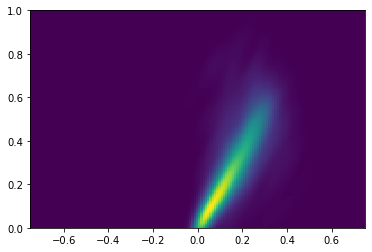

In [202]:
plt.pcolormesh(xs,ys,Zs)
plt.xlim(-0.75,0.75)

In [354]:
5.*np.log10(2.6/10.)

-2.92513326014591

In [345]:
1./0.379*3.086e16/1.5e11

542832.0140721196

In [341]:
33.6*0.52/0.379

46.10026385224275